In [1]:
import csv
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
from math import radians, cos, sin, asin, sqrt
%matplotlib inline

In [44]:
plt.rcParams['figure.figsize'] = (20, 20)

In [10]:
from cartopy import config
import cartopy.crs as ccrs
import geopandas

In [3]:
data = pd.read_csv (r'osm_data.csv')
df = pd.DataFrame(data, columns = ['id', 'latitude', 'longitude', 'description'])

In [36]:
from scipy.spatial import cKDTree 


def get_nearest_entity(input_table, entity_locations):
    """
    Identify which entity locations are nearest to each easting/northing pair in the input_table
    Uses sklearns ckdtree to find the nearest neighbour
    input:
        - input_table: a geodataframe with geometry (points)
        - area_shape: a geodataframe with fields name and geometry (points)
    output:
        nearest_entity
        entity_iloc
    """
    a = np.array(list(input_table.geometry.apply(lambda x: (x.x, x.y))))
    entity_locations_array = np.array(
        list(entity_locations.geometry.apply(lambda x: (x.x, x.y)))
    )
    btree = cKDTree(entity_locations_array)
    distance_to_entity, entity_iloc = btree.query(a, k=1)
    nearest_entity = entity_locations.iloc[entity_iloc].drop(columns="geometry").reset_index(drop=True)
    geo_out = pd.concat([input_table.reset_index(drop=True), nearest_entity, pd.Series(distance_to_entity, name='distance')],axis=1)
    
    return geo_out

In [53]:
vnf_data = pd.read_csv(r'vnf_final.csv')
vnf_df = pd.DataFrame(vnf_data, columns=['id_Key', 'Date_Mscan','Lat_GMTCO','Lon_GMTCO','Temp_BB', 'RHI', 'RH', 'Area_BB', 'Cloud_Mask', 'Sample_M10'])
vnf_df.drop(vnf_df[vnf_df['Temp_BB'] == 999999].index, inplace = True)
vnf_lats = vnf_df['Lat_GMTCO']
vnf_long = vnf_df['Lon_GMTCO']  

In [54]:
gdf = geopandas.GeoDataFrame(
    vnf_df, geometry=geopandas.points_from_xy(vnf_df.Lon_GMTCO, vnf_df.Lat_GMTCO))

In [55]:
gdf_ = geopandas.GeoDataFrame(
    df, geometry=geopandas.points_from_xy(df.longitude, df.latitude))
gdf_ = gdf_.filter(['id', 'geometry'], axis=1)

In [56]:
gdf_.rename(columns={'id': 'name'})

,name,geometry
0,7935809100,POINT (-111.72688 50.55162)
1,7940215218,POINT (-112.25999 50.64888)
2,7435673293,POINT (-97.28850 36.56931)
3,7851363197,POINT (-69.02259 -52.50531)
4,7967393116,POINT (-111.81796 50.00749)
...,...,...
95263,2924263539,POINT (-111.64998 50.98630)
95264,2066567467,POINT (-108.72413 49.57189)
95265,2057571231,POINT (-108.31854 49.10702)
95266,3155385263,POINT (-110.31153 53.32249)


In [57]:
geo = get_nearest_entity(gdf, gdf_)

In [58]:
geo['distance'].max()

111.26037991678415

In [59]:
close_points = geo.loc[geo['distance'] < 1.00]

In [65]:
not_flares = geo.loc[geo['distance'] > 50.00]

In [66]:
not_flares

,id_Key,Date_Mscan,Lat_GMTCO,Lon_GMTCO,Temp_BB,RHI,RH,Area_BB,Cloud_Mask,Sample_M10,geometry,id,distance
317805,x1782699W_y181739S_l3014_s0428_v21,2017/01/04 12:26:48.202,-18.173929,-178.269882,826.0,0.284219,0.288694,10.9594,3.0,428,POINT (-178.26988 -18.17393),588230751,78.003281
401842,x1460510W_y199456S_l1957_s1420_v21,2017/01/09 10:51:39.865,-19.945641,-146.051041,710.0,3.030880,1.836510,127.3090,0.0,1420,POINT (-146.05104 -19.94564),588230751,59.994356
412499,x1516739W_y555864S_l1914_s0135_v21,2017/01/10 09:03:01.951,-55.586376,-151.673859,889.0,0.286903,0.547694,15.4397,3.0,135,POINT (-151.67386 -55.58638),8005203014,79.795554
425210,x1721928W_y579599S_l0283_s0103_v21,2017/01/12 10:07:25.627,-57.959946,-172.192764,914.0,0.281236,0.585913,14.7995,3.0,103,POINT (-172.19276 -57.95995),8005203014,100.420188
439951,x1750689W_y197346S_l0620_s1763_v21,2017/01/13 12:58:19.108,-19.734562,-175.068939,1333.0,7.930780,4.757170,26.5317,3.0,1763,POINT (-175.06894 -19.73456),588230751,76.762342
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1153434,x1740162W_y048171N_l0108_s3198_v30,2017/12/22 13:59:47.227,4.817139,-174.016205,971.0,0.926757,2.487370,49.4422,2.0,3198,POINT (-174.01621 4.81714),2193977678,60.996379
1154342,x1345916W_y249742S_l0117_s0023_v30,2017/12/22 09:05:20.857,-24.974178,-134.591629,969.0,0.896694,2.314180,46.3364,3.0,23,POINT (-134.59163 -24.97418),6198617833,56.497841
1154969,x1558858W_y399453S_l0678_s2847_v30,2017/12/23 12:12:18.714,-39.945267,-155.885849,881.0,0.281295,0.326893,9.5765,3.0,2847,POINT (-155.88585 -39.94527),6198617833,81.589576
1162964,x1588891W_y140287S_l0524_s3199_v30,2017/12/26 12:49:07.266,-14.028657,-158.889130,921.0,1.166970,3.162530,77.4688,3.0,3199,POINT (-158.88913 -14.02866),588230751,61.709499


In [60]:
lat = close_points['Lat_GMTCO']
lon = close_points['Lon_GMTCO']

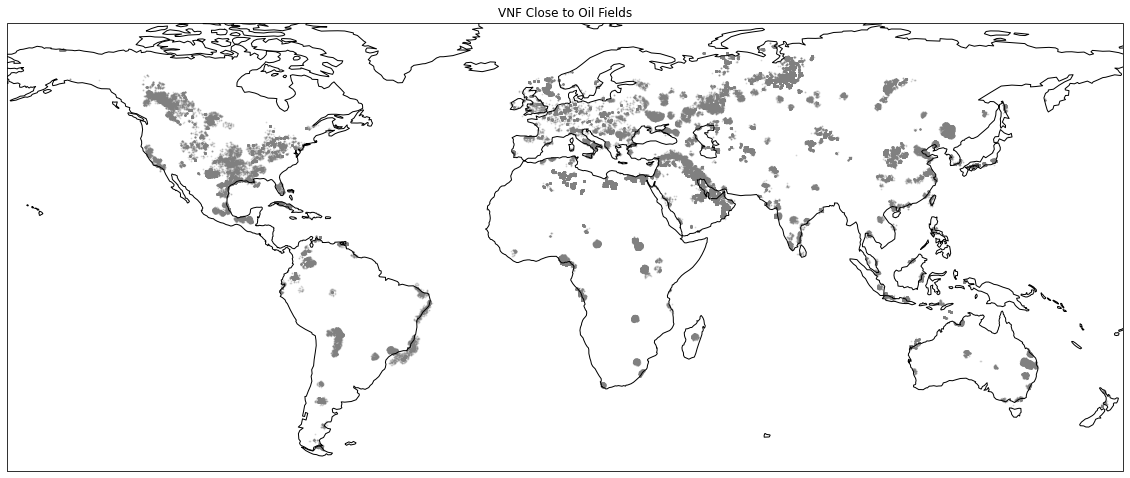

In [62]:
ax = plt.axes(projection=ccrs.PlateCarree())
plt.title('VNF Close to Oil Fields')
ax.coastlines(resolution='110m')
plt.scatter(lon, lat, marker='o', color='gray', alpha=0.2, label='vnf', s=1)
plt.show()

In [63]:
close_points.to_csv("close_points.csv")

In [67]:
not_flares.to_csv("not_flares.csv")